<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.875 · Deep Learning · PEC1</p>
<p style="margin: 0; text-align:right;">2021-2 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PEC 1: Redes neuronales artificiales

En esta práctica implementaremos redes neuronales artificiales para resolver problemas de:

   - Clasificación
   - Regresión   


**Importante: La entrega debe hacerse en formato notebook y en formato html donde se vea el código y los resultados y comentarios de cada ejercicio. Para exportar el notebook a html puede hacerse desde el menú File $\to$ Download as $\to$ HTML.**

<div class="alert alert-block alert-success">
<strong>Javier Gómez de Diego</strong>
</div>

## 0. Contexto y carga de librerías

El siguiente código carga los paquetes necesarios para la práctica y lee el fichero de datos que usaremos.

Los datos contienen información sobre coches de segunda mano, sus características y el precio de re-venta en euros. En un primer ejercicio diseñaremos un modelo que nos permita clasificar los coches en tres grupos según su gama de precio. En el segundo ejercicio diseñaremos un modelo de regresión para predecir el precio de re-venta.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import timeit

import keras
from keras.models import Sequential, Model
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD, Adadelta, Adagrad

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [2]:
#Set seeds for reproducibles results
import tensorflow as tf
import random as rn
import os
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
rn.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
from keras import backend as K
tf.compat.v1.set_random_seed(1234)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

In [3]:
df = pd.read_csv("dataset.csv")

In [4]:
df.head(5)

,months_old,km,fuel_type,horsepower,metcolor,automatic,size_engine,doors_num,weight,price
0,73,97494,Petrol,110,1,0,1600,5,1085,10950
1,48,89049,Petrol,97,1,0,1400,5,1060,13500
2,40,161000,Diesel,69,1,0,1900,3,1105,13950
3,37,38812,Petrol,97,0,0,1400,3,1025,13450
4,55,33230,Petrol,110,0,0,1600,3,1050,13500


## 1. Exploración (1 punto)



En primer lugar exploraremos el conjunto de datos. 

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio (1 punto):</strong> Explora los datos: 

<ul>
        
<li> Indica el tamaño del dataset y el número de variables categóricas y continuas del conjunto de datos</li> 
<li>   Grafica las distribuciones de las variables categóricas y de las continuas</li>
<li>    Genera una tabla de correlaciones de todas las variables usando la librería <code>seaborn</code>, mostrando en cada casilla el valor de la correlación</li>
<li>    Genera una tabla (usando la librería <code>seaborn</code>) que muestre únicamente las correlaciones entre el precio y el resto de variables, ordenada de mayor a menor según los valores de correlación</li>
<li>  Comenta los resultados de la exploración de datos</li>
</ul>

</div>



*   **Variables**



In [5]:
#Dataset size
df.size

14360

In [6]:
#Explore data types
df.dtypes

months_old      int64
km              int64
fuel_type      object
horsepower      int64
metcolor        int64
automatic       int64
size_engine     int64
doors_num       int64
weight          int64
price           int64
dtype: object

In [7]:
#Convert to categorical
df['fuel_type'] = df['fuel_type'].astype('category')
df['metcolor'] = df['metcolor'].astype('category')
df['automatic'] = df['automatic'].astype('category')
df['doors_num'] = df['doors_num'].astype('category')

In [8]:
#Number of categorical and continuous variables
num_categorical_variables = df.select_dtypes(include=['category']).columns.size
num_continuous_variables = df.select_dtypes(include=['number']).columns.size

*   **Distribuciones**





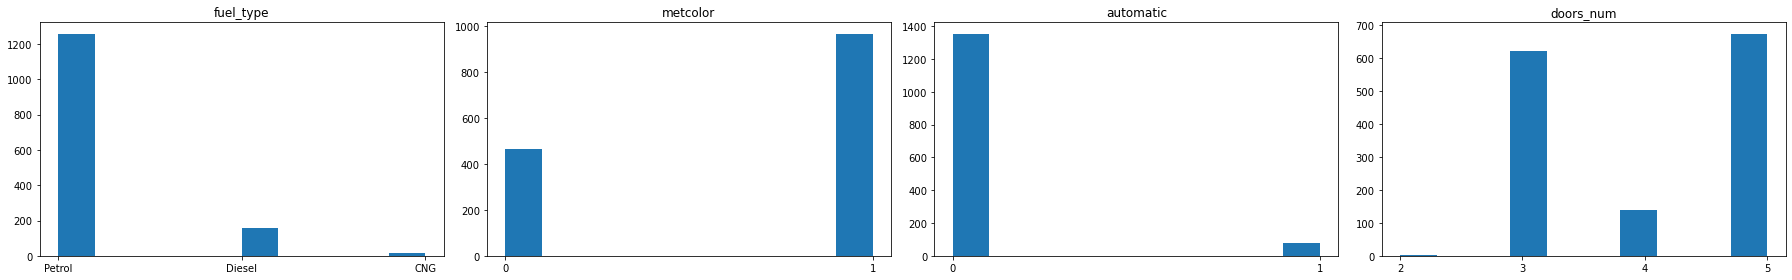

In [9]:
#Distributions of categorical variables
fig, ax = plt.subplots(nrows=1, ncols=num_categorical_variables, figsize=(25,4))

for i in range(num_categorical_variables):
    ax[i].hist(df.select_dtypes(include=['category']).iloc[:,i])
    ax[i].set_title(df.select_dtypes(include=['category']).columns[i])
    ax[i].set_xticks(df.select_dtypes(include=['category']).iloc[:,i].unique())
plt.tight_layout()

In [10]:
#Rename 'fuel_type' categories for numbers
df['fuel_type'] = df['fuel_type'].cat.rename_categories({'Petrol': 0, 'Diesel': 1, 'CNG': 2})

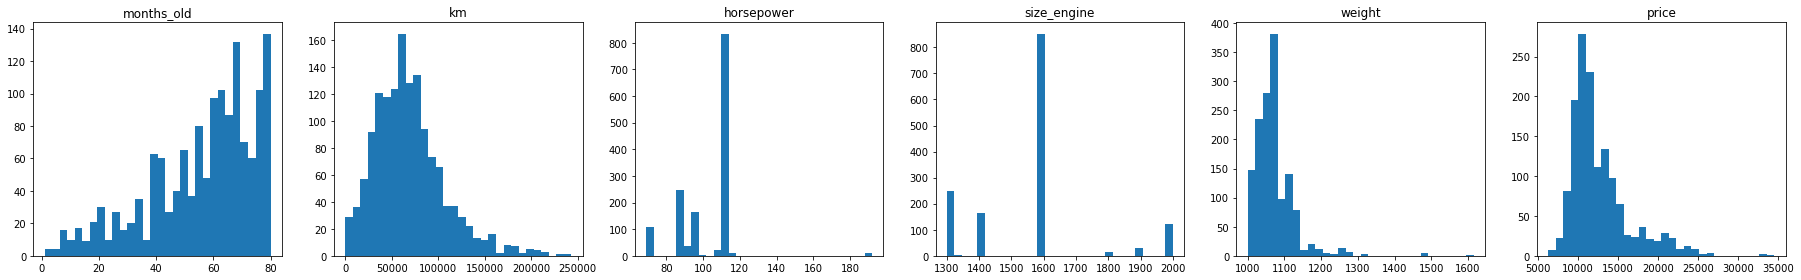

In [11]:
#Distributions continuous variables
fig, ax = plt.subplots(nrows=1, ncols=num_continuous_variables, figsize=(25,4))

for i in range(num_continuous_variables):
    ax[i].hist(df.select_dtypes(include=['number']).iloc[:,i], bins=30)
    ax[i].set_title(df.select_dtypes(include=['number']).columns[i])
plt.tight_layout()

*   **Correlaciones**




<AxesSubplot:>

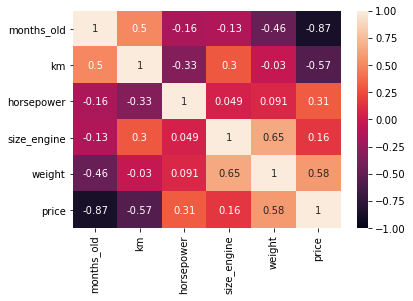

In [12]:
#All variables correlations
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)

<AxesSubplot:>

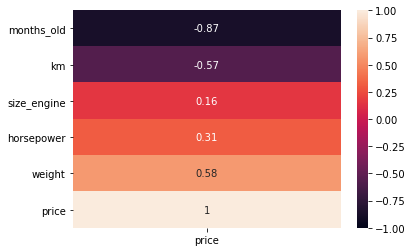

In [13]:
#Features correlating with Price and sorted
sns.heatmap(df.corr().loc[['price'],:].T.sort_values(by=['price']), vmin=-1, vmax=1, annot=True)



*   **Comentarios resultado exploración**



<div class="alert alert-block alert-success">
<strong>Respuesta:</strong><br><br>

<font color=#679532>El <i>dataset</i> cuenta con <b><i>14360</i> filas</b> y <b><i>10</i> variables</b>.<br>

<font color=#679532>Todas las variables eran inicialmente numéricas salvo una (tipo objeto). Sin embargo, algunas de ellas eran realmente categóricas pero estaban codificadas numéricamente (utilizando <b><i>0</i></b> y <b><i>1</i></b> para las binarias, o con valores enteros de <b><i>2</i></b> a <b><i>5</i></b>). Por lo tanto, se ha cambiado el tipo de dato de estas variables a categóricas.<br><br>

<hr>
<br>
<font color=#679532>En cuanto a las distribuciones de las variables <b>categóricas</b>, se ha observado lo siguiente:<br><br>
    
- <font color=#679532><b><i>fuel_type</i></b>: toma tres valores. El más repetido es, con diferencia, el valor <b><i>Petrol</i></b> (><b><i>1.200</i></b> registros), seguido de <b><i>Diesel</i></b> (<<b><i>200</i></b> registros) y <b><i>CNG</i></b> (<<b><i>50</i></b> registros).<br>
- <font color=#679532><b><i>metcolor</i></b>: es una variable binaria. Toma el valor <b><i>0</i></b> algo menos de <b><i>500</i></b> veces, y el valor <b><i>1</i></b> el resto.<br>
- <font color=#679532><b><i>automatic</i></b>: también es binaria. Toma el valor <b><i>0</i></b> algo menos de <b><i>1.400</i></b> veces, y el valor <b><i>1</i></b> el resto.<br><br>

<font color=#679532>En cuanto a las distribuciones de las variables <b>continuas</b>:<br><br>

- <font color=#679532><b><i>months_old</i></b>: toma valores de <b><i>0</i></b> a <b><i>80</i></b>, existiendo una tendencia ascendente hacia una mayor antigüedad de los vehículos.<br>
- <font color=#679532><b><i>km</i></b>: toma valores de <b><i>0</i></b> a <b><i>250.000</i></b> aporx., con una frecuencia centrada en torno a <b><i>50.000</i> km</b> y una cola a la derecha de la distribución que la hace asimétrica.<br>
- <font color=#679532><b><i>horsepower</i></b>: la frecuencia de algunos valores es muy alta, mientras que no existen registros en muchos de los valores intermedios, lo que la hace asemejarse a una variable categórica. Más de la mitad de los vehículos tienen unos valores de entre <b><i>100</i></b> y <b><i>120</i></b> caballos de potencia.<br>
- <font color=#679532><b><i>size_engine</i></b>: ocurre lo mismo que con la variable anterior. La mayoría de los vehículos registran los mismos valores, cerca de <b><i>1600</i></b> $cm^3$.<br>
- <font color=#679532><b><i>weight</i></b>: toma valores de <b><i>1.000</i></b> a <b><i>1.600</i></b> aporx., con una frecuencia centrada en torno a <b><i>1.075</i> kg</b> y una cola a la derecha de la distribución (bastante plana) que, junto a algunos <i>outliers</i>, la hace asimétrica.<br>
- <font color=#679532><b><i>price</i></b>: la variable objetivo. Toma valores de <b><i>5.000</i></b> a <b><i>35.000</i></b> aporx., con una frecuencia centrada en torno a <b><i>11.000</i> dólares</b> y una cola a la derecha de la distribución (bastante plana) que la hace asimétrica.<br><br>

<hr>
<br>
<font color=#679532>En cuanto a las <b>correlaciones</b>, destaca la que existe entre <b><i>months_old</i></b> y <b><i>price</i></b> de <b><i>-0,87</i></b>, lo que indica una correlación fuerte negativa entre ambas. Es decir, cuanto mayor es la antigüedad en meses de un vehículo, hay una fuerte tendencia a que su precio disminuya; y viceversa.

<font color=#679532>También se podría destacar la correlación positiva entre <b><i>weight</i></b> y <b><i>size_engine</i></b> (<i>0,65</i>), que indica una cierta tendencia de que a mayor tamaño del motor, mayor peso.

<font color=#679532> Las correlaciones más bajas son las que se dan entre:<br><br>

- <font color=#679532><b><i>weight</i></b> y <b><i>km</i></b> (<i>-0,03</i>)<br>
- <font color=#679532><b><i>size_engine</i></b> y <b><i>months_old</i></b> (<i>-0,13</i>)<br>
- <font color=#679532><b><i>horsepower</i></b> y <b><i>months_old</i></b> (<i>-0,16</i>)<br>
- <font color=#679532><b><i>price</i></b> y <b><i>size_engine</i></b> (<i>0,16</i>).<br>

</div>

## 2. Red neuronal artificial: Clasificación (4.5 puntos)


En este apartado entrenaremos un modelo que intente clasificar los coches según su gama de precio. Para ello crearemos una nueva variable como indicador de calidad del coche (gama baja, media o alta), siguiendo las siguientes condiciones:



*   _low-end_: precio menor que 11000 euros
*   _medium-end_: precio mayor o igual que 11000 euros y menor que 13000
*   _high-end_: precio mayor o igual que 13000



### Pre-procesado


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio (0.75 puntos):</strong> Pre-procesa los datos: 

<ul>
        
<li>   Crea una nueva variable <code>quality</code> que incluya la gama del coche, con las condiciones indicadas</li>
<li>   Muestra el histograma de la nueva variable <code>quality</code></li>
<li>   Crea los vectores de variables dependientes (<i>features</i>) y de la variable independiente (<i>labels</i>)</li>
<li>   Normaliza debidamente los datos y binariza el vector de etiquetas (<i>labels</i>) </li>
<li>   Divide el conjunto de datos en 80% para entrenamiento y 20% para test, usando la función <code>train_test_split</code></li>
<li>   Muestra las dimensiones de los conjuntos de entrenamiento y test</li>
</ul>
</div>

In [14]:
#Create new variable: quality
pd.options.mode.chained_assignment = None
df['quality'] = ''
df['quality'].loc[df['price'] < 11000] = 'low-end'
df['quality'].loc[(df['price'] >= 11000) & (df['price'] < 13000)] = 'medium-end'
df['quality'].loc[df['price'] >= 13000] = 'high-end'
df['quality'] = df['quality'].astype('category')

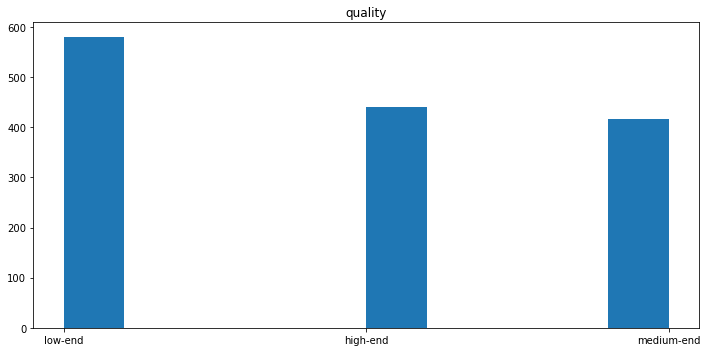

In [15]:
#Histogram car quality
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
ax.hist(df['quality'])
ax.set_title('quality')
ax.set_xticks(df['quality'].unique())
plt.tight_layout()

In [16]:
#Create features and labels vectors
features = df.loc[:, (df.columns != 'price') & (df.columns != 'quality')]
labels = df.loc[:, df.columns == 'quality']

In [17]:
#Normalize the corresponding data
scaler = StandardScaler()
features[features.select_dtypes(include=['number']).columns] = scaler.fit_transform(features.select_dtypes(include=['number']))
features = features.values

In [18]:
#Binarize the labels
ohe = OneHotEncoder()
ohe_df = pd.DataFrame(ohe.fit_transform(labels[['quality']]).toarray())
labels = labels.join(ohe_df.astype('int')).drop('quality', 1).values

In [19]:
#Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, labels, train_size = 0.8)

In [20]:
#Shapes
print('Fetures de entrenamiento: ', X_train.shape)
print('Labels de entrenamiento: ', y_train.shape)
print('Fetures de test: ', X_test.shape)
print('Labels de test: ', y_test.shape)

Fetures de entrenamiento:  (1148, 9)
Labels de entrenamiento:  (1148, 3)
Fetures de test:  (288, 9)
Labels de test:  (288, 3)


### Modelo base


Empezaremos diseñando un modelo base con 4 capas ocultas.
 
Nota: Para el ajuste del modelo usaremos los datos de test como conjunto de validación.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio (1.25 puntos):</strong> Implementa el modelo de red neuronal artificial:
<ul>
<li>   Diseña la arquitectura para el modelo de clasificación con la función de activación adecuada para la capa de salida y con las siguientes características:</li>
   <ul>
   <li> 4 capas ocultas con 64, 32, 10, 8 neuronas sucesivamente</li>
   <li> Función de activación de las capas intermedias: ReLU</li>
   </ul>

<li>   Compila el modelo con la función de pérdida más adecuada, el optimizador Adam, una velocidad de aprendizaje de 0.1, y la métrica Accuracy.</li>

<li>   Ajusta el modelo con 20 épocas y un tamaño del batch de 64</li>

<li>   Muestra las gráficas de accuracy y loss. En cada gráfica debe visualizarse la curva de entrenamiento y la de validación</li>
</ul>
</div>

In [21]:
#Create ANN model
b = Sequential(name='Base')

b.add(Dense(64, input_dim=X_train.shape[1], activation='relu', name='h1'))
b.add(Dense(32, activation='relu', name='h2'))
b.add(Dense(10, activation='relu', name='h3'))
b.add(Dense(8, activation='relu', name='h4'))

b.add(Dense(y_train.shape[1], activation='softmax', name='output'))

b.summary()

Model: "Base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 h1 (Dense)                  (None, 64)                640       
                                                                 
 h2 (Dense)                  (None, 32)                2080      
                                                                 
 h3 (Dense)                  (None, 10)                330       
                                                                 
 h4 (Dense)                  (None, 8)                 88        
                                                                 
 output (Dense)              (None, 3)                 27        
                                                                 
Total params: 3,165
Trainable params: 3,165
Non-trainable params: 0
_________________________________________________________________


In [22]:
#Compile
b.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.1), metrics=['accuracy'])

In [23]:
#Fit
bfit = b.fit(X_train, y_train, epochs=20 , batch_size=64, validation_data = (X_test, y_test), verbose = 0)

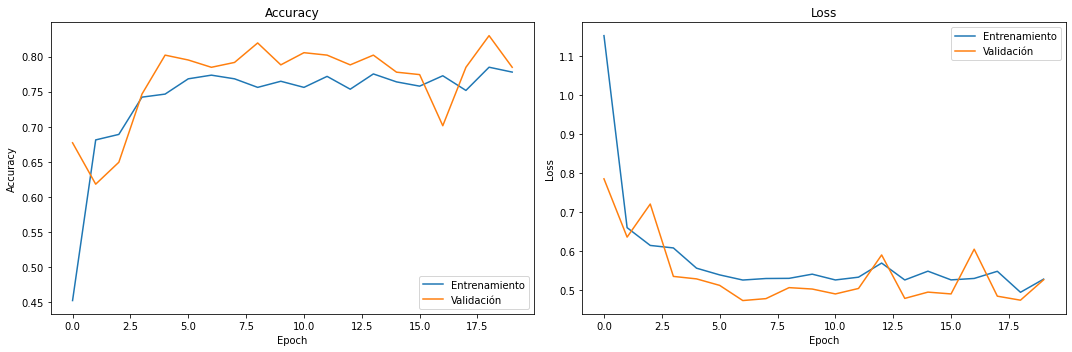

In [24]:
#Plots 
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

ax[0].plot(bfit.history['accuracy'])
ax[0].plot(bfit.history['val_accuracy'])
ax[0].set_title('Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Entrenamiento', 'Validación'], loc='lower right')
ax[1].plot(bfit.history['loss'])
ax[1].plot(bfit.history['val_loss'])
ax[1].set_title('Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Entrenamiento', 'Validación'], loc='upper right')
plt.tight_layout()

### Influencia velocidad aprendizaje y optimizador

Una vez tenemos el modelo base, analizaremos la influencia que pueden tener la velocidad de aprendizaje y el tipo de optimizador en la mejora del rendimiento.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio (1.5 puntos):</strong> Implementa una función para entrenar la arquitectura del ejercicio anterior para 4 optimizadores diferentes: Adam, SGD, Adadelta, Adagrad, y 4 velocidades de aprendizaje: 0.001, 0.01, 0.05, 0.1. 
Entrena los modelos, y representa dos gráficas:
 <ul>
     <li> Tiempo de entrenamiento vs Velocidad de aprendizaje</li>
     <li> <i>Accuracy</i> vs Velocidad de aprendizaje</li>
</ul>   
    
Cada gráfica debe incluir la evolución obtenida por los cuatro optimizadores para poderlos comparar mejor.
    
-----------------------------------------------------------------------------------------------------------
<b>Importante</b>: para la entrega de la PEC, fijar el parámetro <code>verbose = 0</code> en el entrenamiento de los modelos. La solución únicamente debe mostrar las gráficas resultantes.
</div>

In [25]:
#Function to compute several models changing Optimizers and learning rate
import time
def multimodel(opt, lr):
    models = []
    times = []
    accuracies = []
    for i in opt:
        for j in lr:
            b.compile(loss='categorical_crossentropy',
                      optimizer=i(learning_rate=j),
                      metrics=['accuracy']
                     )
            start = time.time()
            bfit = b.fit(X_train,
                         y_train,
                         epochs=20,
                         batch_size=64,
                         validation_data = (X_test, y_test),
                         verbose = 0
                        )
            end = time.time()
            times.append(end - start)
            models.append(b)
            accuracies.append(bfit.history['val_accuracy'][-1])
    return models, times, accuracies

In [26]:
#Compute models
opt = [Adam, SGD, Adadelta, Adagrad]
lr = [0.001, 0.01, 0.05, 0.1]
m, t, a = multimodel(opt, lr)

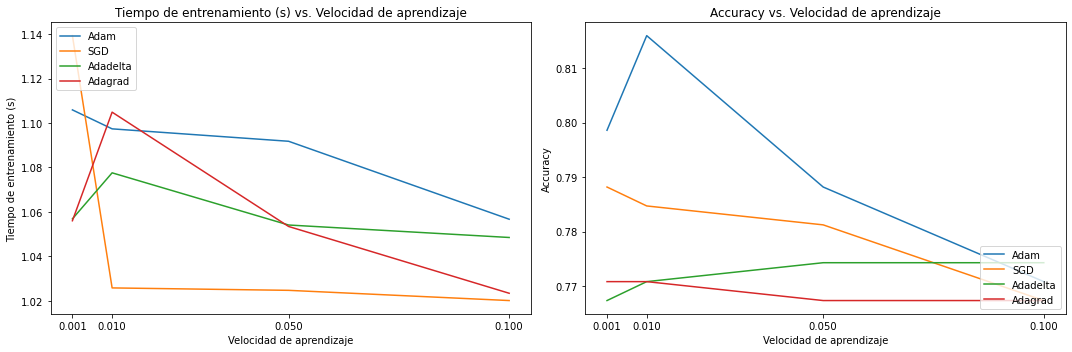

In [27]:
#Plots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

for i in range(0, len(t), len(lr)):
    ax[0].plot(lr, t[i:(i+len(lr))])
ax[0].set_title('Tiempo de entrenamiento (s) vs. Velocidad de aprendizaje')
ax[0].set_ylabel('Tiempo de entrenamiento (s)')
ax[0].set_xlabel('Velocidad de aprendizaje')
ax[0].set_xticks(lr)
ax[0].legend([i.__name__ for i in opt], loc='upper left')

for i in range(0, len(t), len(lr)):
    ax[1].plot(lr, a[i:(i+len(lr))])
ax[1].set_title('Accuracy vs. Velocidad de aprendizaje')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Velocidad de aprendizaje')
ax[1].set_xticks(lr)
ax[1].legend([i.__name__ for i in opt], loc='lower right')

plt.tight_layout()

### Elección del mejor modelo

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio (1 punto):</strong> Identifica el valor de la velocidad de aprendizaje y del optimizador que mejor rendimiento dan al modelo, según los resultados del ejercicio anterior:
<ul>
    
<li>   Justifica la elección</li>
<li>   Compila y entrena el modelo elegido</li>
<li>   Muestra las correspondientes gráficas de <i>Accuracy</i> y <i>Loss</i> de los conjuntos de entrenamiento y validación, e indica el <i>Accuracy</i> del modelo </li>
<li>   Muestra la matriz de confusión multi-clase con las etiquetas originales de <code>quality</code> (<i>low-end</i>, <i>medium-end</i>, <i>high-end</i>)</li>
<li>   Muestra la precisión, recall y F1-score resultantes para cada etiqueta</li>
<li>   Comenta los resultados obtenidos</li>
</ul>
</div>

<div class="alert alert-block alert-success">
<strong>Respuesta:</strong><br><br>

<font color=#679532>Se trata de minimizar el <b>tiempo de entrenamiento</b> y maximizar el <b><i>accuracy</i></b>. Por lo tanto, podemos estandarizar y calcular <b><i>tiempo de entrenamiento - accuracy * 1.5</i></b> y escoger el modelo que menor resulatdo presente, estandarizando previamente y dando más peso a <i>accuracy</i>.

</div>

In [28]:
#Best model justification
scaler = StandardScaler()
st = scaler.fit_transform(np.reshape(t,(-1,1)))
sa = scaler.fit_transform(np.reshape(a,(-1,1)))

cal = [x-(y*1.5) for x, y in zip(st, sa)]
index = cal.index(min(cal))
bopt = opt[int(index/len(opt))]
blr = lr[int(index%len(lr))]
print('El mejor optimizador es: ', bopt.__name__)
print('El mejor learning rate es: ', blr)

El mejor optimizador es:  Adam
El mejor learning rate es:  0.01


In [29]:
#Create, compile and fit ANN BEST model
#Already created: b
b.compile(loss='binary_crossentropy', optimizer=bopt(learning_rate=blr), metrics=['accuracy'])
bfit = b.fit(X_train, y_train, epochs=20 , batch_size=64, validation_data = (X_test, y_test), verbose = 0)

Accuracy:  0.7882


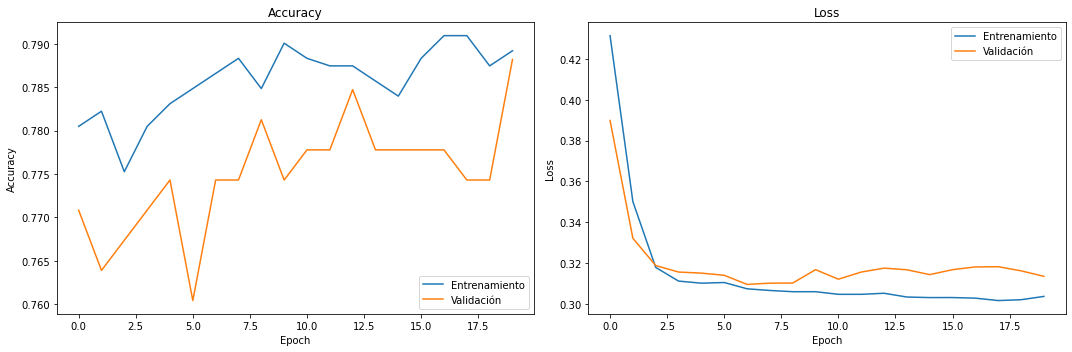

In [30]:
#Plots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

ax[0].plot(bfit.history['accuracy'])
ax[0].plot(bfit.history['val_accuracy'])
ax[0].set_title('Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Entrenamiento', 'Validación'], loc='lower right')
ax[1].plot(bfit.history['loss'])
ax[1].plot(bfit.history['val_loss'])
ax[1].set_title('Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Entrenamiento', 'Validación'], loc='upper right')
plt.tight_layout()
print('Accuracy: ', round(bfit.history['val_accuracy'][-1], 4))

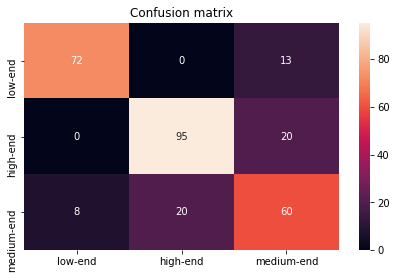

In [31]:
#Confusion matrix
y_pred = b.predict(X_test)
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g')
ax.set_xticklabels(df['quality'].unique())
ax.set_yticklabels(df['quality'].unique())
ax.set_title('Confusion matrix')
plt.tight_layout()

In [32]:
#Accuracy
print('Accuracy: ', round(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names=df['quality'].unique(), output_dict=True)['accuracy'], 4))

Accuracy:  0.7882


In [33]:
#Precision, Recall and F1-score for each label
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names=df['quality'].unique()))

              precision    recall  f1-score   support

     low-end       0.90      0.85      0.87        85
    high-end       0.83      0.83      0.83       115
  medium-end       0.65      0.68      0.66        88

    accuracy                           0.79       288
   macro avg       0.79      0.78      0.79       288
weighted avg       0.79      0.79      0.79       288



<div class="alert alert-block alert-success">
<strong>Respuesta:</strong><br><br>

<font color=#679532>El modelo que presenta un mejor rendimiento en cuanto al tiempo de ejecución y al <i>accuracy</i> (este último con un 50% más de peso) utiliza como optimizador <b><i>Adam</i></b> y un <b><i>learning rate</i></b> de <b><i>0.01</i></b>. Este modelo presenta un <i>accuracy</i> de <b><i>0.7882</i></b> que, pese a no ser un resultado extraordinario, muestra una buena capacidad predictora, especialmente teniendo en cuenta que se ha logrado tras 20 <i>epochs</i>.

<font color=#679532>La matriz de confusión evidencia que los aciertos de modelo son mayoritarios. Sin embargo, existe cierta dificultad a la hora de clasificar la clase <b><i>medium_end</i></b>, y esto se refleja tanto en la precisión (<b><i>0.65</i></b>), <i>recall</i> (<b><i>0.68</i></b>) y <i>f1-score</i> (<b><i>0.66</i></b>). Esto se puede deber a que esta clase está acotada tanto por arriba como por abajo, por lo que su clasificación puede llevar a más errores.

<font color=#679532>En contraste, las clases <b><i>low_end</i></b> y <b><i>high_end</i></b> muestran unas métricas muy buenas.

</div>

## 3. Red neuronal artificial: Regresión (4.5 puntos)

En este apartado resolveremos un problema de regresión intentando predecir el precio de re-venta según las características de los coches. Partiremos del conjunto de datos original.

### Pre-procesado




<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio (0.5 puntos):</strong> Pre-procesa los datos: 
<ul>
<li>   Crea los vectores de variables dependientes (<i>features</i>) y de la variable independiente (<i>target</i>)</li>
<li>   Normaliza debidamente los datos</li>
<li>   Divide el conjunto de datos en 70% para entrenamiento y 30% para test, usando la función <code>train_test_split</code></li>
<li>   Muestra las dimensiones de los conjuntos de entrenamiento y test</li>
</ul>
</div>

In [34]:
#Create features and target vectors
features = df.loc[:, (df.columns != 'price') & (df.columns != 'quality')]
target = df.loc[:, df.columns == 'price']

In [35]:
#Normalizing the data
scaler = StandardScaler()
features[features.select_dtypes(include=['number']).columns] = scaler.fit_transform(features.select_dtypes(include=['number']))
features = features.values
target = scaler.fit_transform(target)

In [36]:
#Split train-test
X_train, X_test, y_train, y_test = train_test_split(features, target, train_size = .7)

In [37]:
#Dimensions
print('Fetures de entrenamiento: ', X_train.shape)
print('Target de entrenamiento: ', y_train.shape)
print('Fetures de test: ', X_test.shape)
print('Target de test: ', y_test.shape)

Fetures de entrenamiento:  (1005, 9)
Target de entrenamiento:  (1005, 1)
Fetures de test:  (431, 9)
Target de test:  (431, 1)


### Modelo base

En primer lugar diseñaremos un modelo base con tres capas ocultas.

Nota: Para el ajuste del modelo usaremos los datos de test como conjunto de validación.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio (1 punto):</strong> Implementa el modelo de red neuronal artificial:
<ul>
<li>Diseña la arquitectura para el modelo de regresión con las siguientes características:</li>
    <ul>
   <li>1 primera capa oculta completamente conectada de 128 neuronas y activación ReLU</li>
   <li>2 capas ocultas de 32 y 16 neuronas y activación tangencial</li>
   <li>Todas las capas deben tener <code>kernel_initizalizer</code> en modo 'normal'</li>
   </ul>
<li>Compila el modelo con la función de pérdida más adecuada y el optimizador Adam</li>

<li>Ajusta el modelo con 50 épocas y un tamaño del batch de 32</li>

<li>Muestra la gráfica de pérdida. En la gráfica debe visualizarse la curva de entrenamiento y la de validación</li>
</ul>
</div>

In [38]:
#Create ANN model
b = Sequential(name='Base')

b.add(Dense(128, input_dim=X_train.shape[1], activation='relu', kernel_initializer='normal', name='h1'))
b.add(Dense(32, activation='tanh', kernel_initializer='normal', name='h2'))
b.add(Dense(16, activation='tanh', kernel_initializer='normal', name='h3'))

b.add(Dense(y_train.shape[1], kernel_initializer='normal', name='output'))

b.summary()

Model: "Base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 h1 (Dense)                  (None, 128)               1280      
                                                                 
 h2 (Dense)                  (None, 32)                4128      
                                                                 
 h3 (Dense)                  (None, 16)                528       
                                                                 
 output (Dense)              (None, 1)                 17        
                                                                 
Total params: 5,953
Trainable params: 5,953
Non-trainable params: 0
_________________________________________________________________


In [39]:
#Compiling the model
b.compile(loss='mse', optimizer='adam')

In [40]:
#Fit model
bfit = b.fit(X_train, y_train, epochs=50, batch_size=32, validation_data = (X_test, y_test), verbose = 0)

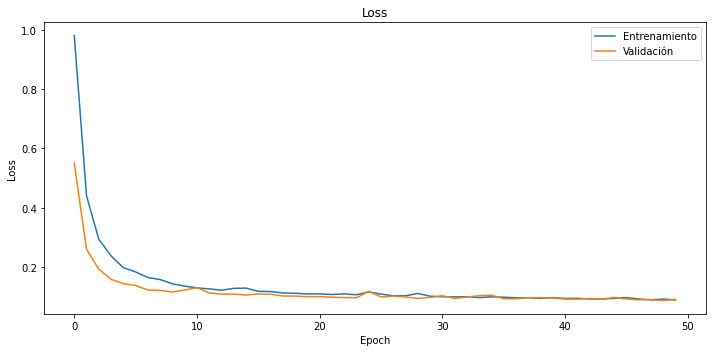

In [41]:
#Plots
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

ax.plot(bfit.history['loss'])
ax.plot(bfit.history['val_loss'])
ax.set_title('Loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(['Entrenamiento', 'Validación'], loc='upper right')
plt.tight_layout()

### Búsqueda hiperparámetros

Una vez tenemos el modelo base nos interesa buscar la configuración de hiperparámetros que nos proporcione una mejor predicción del precio de re-venta de los coches. En este apartado haremos una búsqueda de hiperparámetros, recorriendo varios valores de número de capas, número de neuronas, tamaño del batch y épocas.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio (1.75 puntos):</strong> Implementa una función que evalúe distintos modelos combinando las siguientes características:
<ul>    
   <li>Tres arquitecturas diferentes con las siguientes configuraciones de número de capas ocultas (completamente conectadas) y número de neuronas en cada capa:</li>
        <ul>
        <li>[128, 64, 16]</li>
        <li>[16, 4]</li>
        <li>[4, 4]</li>
        </ul> 
   <li>Tamaño del batch de 16 y 32</li>
   <li>Épocas de 20, 50 y 100</li>
</ul>   
    
    
Como en el ejercicio anterior, la primera capa oculta tendrá siempre activación ReLU y las demás activación tangencial. El inicializador de kernel estará en modo 'normal' y usaremos el optimizador Adam.

    
La función deberá proporcionar una tabla con los siguientes campos: arquitectura de la red seleccionada, épocas, tamaño del batch, tiempo de entrenamiento, y raíz del error cuadrático medio (RMSE) del modelo 

-----------------------------------------------------------------------------------------------------------
<b>Importante</b>: para la entrega de la PEC, fijar el parámetro <code>verbose = 0</code> en el entrenamiento de los modelos. La solución únicamente debe mostrar la tabla resultante.
</div>

In [42]:
#Hiperparameter search function
def multiparams(layers, batches, epochs):
    models = []
    mdf = pd.DataFrame(columns = ['Capas ocultas', 'Batch', 'Épocas', 'Tiempo entrenamiento', 'RMSE'])
    for n in layers:
        b = Sequential(name='Base')
        for k, l in zip(n, range(len(n))):
            if l==0:
                b.add(Dense(k, input_dim=X_train.shape[1], activation='relu', kernel_initializer='normal', name='h'+str(l+1)))
            elif l==len(n)-1:
                b.add(Dense(k, activation='tanh', kernel_initializer='normal', name='h'+str(l+1)))
                b.add(Dense(y_train.shape[1], kernel_initializer='normal', name='output'))
                b.compile(loss='mean_squared_error', optimizer='adam')
            else:
                b.add(Dense(k, activation='tanh', kernel_initializer='normal', name='h'+str(l+1)))
        for i in batches:
            for j in epochs:
                start = time.time()
                b.fit(X_train, y_train, epochs=j, batch_size=i, validation_data = (X_test, y_test), verbose = 0)
                end = time.time()
                models.append(b)
                tttime = end-start
                y_pred = b.predict(X_test)
                mdf = mdf.append({'Capas ocultas':n,
                                  'Batch':i,
                                  'Épocas':j,
                                  'Tiempo entrenamiento':tttime,
                                  'RMSE':mean_squared_error(y_test, y_pred, squared = False)},
                                 ignore_index=True)
    print(mdf)
    return models, mdf

In [43]:
#Compute search
layers = [[128, 64, 16],
          [16, 4],
          [4, 4]]
batches = [16, 32]
epochs = [20, 50, 100]
m, mdf = multiparams(layers = layers, batches = batches, epochs = epochs)

    Capas ocultas Batch Épocas  Tiempo entrenamiento      RMSE
0   [128, 64, 16]    16     20              2.092205  0.309372
1   [128, 64, 16]    16     50              4.782994  0.295773
2   [128, 64, 16]    16    100              9.030965  0.309079
3   [128, 64, 16]    32     20              1.125180  0.315562
4   [128, 64, 16]    32     50              2.742042  0.327134
5   [128, 64, 16]    32    100              5.454327  0.348284
6         [16, 4]    16     20              1.941447  0.355732
7         [16, 4]    16     50              4.226765  0.308927
8         [16, 4]    16    100              8.427703  0.290843
9         [16, 4]    32     20              1.060506  0.290829
10        [16, 4]    32     50              2.554740  0.289468
11        [16, 4]    32    100              5.038176  0.292367
12         [4, 4]    16     20              1.867693  0.358671
13         [4, 4]    16     50              4.154897  0.320244
14         [4, 4]    16    100              8.358837  0

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio (0.25 puntos):</strong> Representa en un gráfico el RMSE vs la configuración de los modelos 

</div>

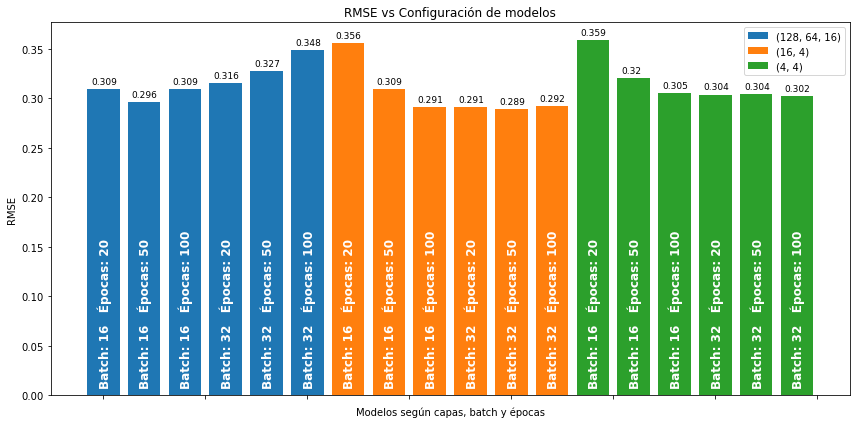

In [44]:
#Plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))

nu = mdf['Capas ocultas'].map(tuple).nunique()
steps = int(len(mdf)/nu)
for i, j in zip(range(0, len(mdf), steps), range(steps)):
    ax.bar(list(range(i, i+steps)), list(mdf['RMSE'].iloc[i:i+steps]))

for i in range(len(mdf)):
    ax.text(i-.15,
            .01,
            'Batch: ' + str(mdf['Batch'][i]) + '   Épocas: ' + str(mdf['Épocas'][i]),
            color='White',
            fontweight='bold',
            fontsize=12,
            rotation=90)
    ax.text(i-.3,
            mdf['RMSE'][i]+.005,
            round(mdf['RMSE'][i], 3),
            color='Black',
            fontweight='light',
            fontsize=9)
ax.set_title('RMSE vs Configuración de modelos')
ax.legend(mdf['Capas ocultas'].map(tuple).unique())
ax.set_xticklabels('')
ax.set_ylabel('RMSE')
ax.set_xlabel('Modelos según capas, batch y épocas')
plt.tight_layout()

### Elección mejor modelo y predicción

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio (1 punto):</strong> Identifica la configuración que proporciona mejores resultados:
<ul> 
<li>Justifica la elección del modelo</li>
<li>Compila y entrena el modelo elegido. Nota: para la entrega, presentar con verbose=0</li>
<li>Muestra la correspondiente gráfica de pérdida de los conjuntos de entrenamiento y validación</li>
<li>Calcula las predicciones del precio y muestra en una tabla el Precio original (<code>price</code>) y el Precio predicho (<code>predicted_price</code>) para las 10 primeras filas del conjunto de test</li>
<li>Comenta los resultados obtenidos</li>
</ul> 
</div>

<div class="alert alert-block alert-success">
<strong>Respuesta:</strong><br><br>

<font color=#679532>Se trata de minimizar tanto el <b>tiempo de entrenamiento</b> como el <b><i>RMSE</i></b>. Por lo tanto, podemos estandarizar y calcular <b><i>tiempo de entrenamiento + RMSE * 1.5</i></b> y escoger el modelo que menor resulatdo presente, estandarizando previamente y dando más peso a <i>RMSE</i>.

</div>

In [45]:
#Best configuration justification
scal = StandardScaler()
st = scal.fit_transform(mdf[['Tiempo entrenamiento']])
srmse = scal.fit_transform(mdf[['RMSE']])

cal = [x+(y*1.5) for x, y in zip(st, srmse)]
index = cal.index(min(cal))
blayers = mdf['Capas ocultas'].iloc[index]
bbatch = mdf['Batch'].iloc[index]
bepochs = mdf['Épocas'].iloc[index]
print('La mejor configuración de capas ocultas es:\t', blayers)
print('La mejor configuración de batch es:\t\t', bbatch)
print('La mejor configuración de épocas es:\t\t', bepochs)

La mejor configuración de capas ocultas es:	 [16, 4]
La mejor configuración de batch es:		 32
La mejor configuración de épocas es:		 20


In [46]:
#Create, compile and fit ANN best model
#Already created and compiled: it is in vector 'm'
bfit = m[index].fit(X_train, y_train, epochs=bepochs, batch_size=bbatch, validation_data = (X_test, y_test), verbose = 0)

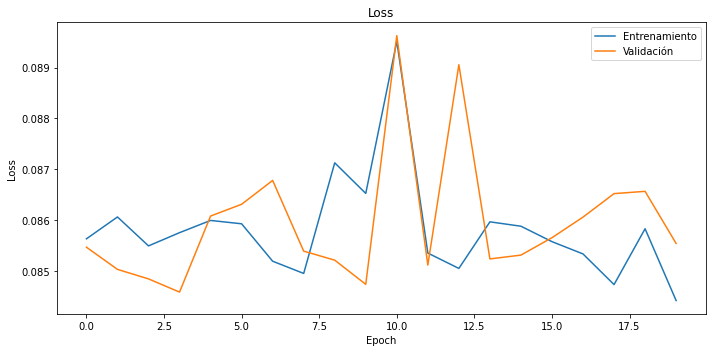

In [47]:
#Plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

ax.plot(bfit.history['loss'])
ax.plot(bfit.history['val_loss'])
ax.set_title('Loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(['Entrenamiento', 'Validación'], loc='upper right')
plt.tight_layout()

In [48]:
#Generate Predictions on testing data
y_pred = m[index].predict(X_test)
y_pred = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)
results = pd.DataFrame({'price':y_test_inv.flatten(), 'predicted_price':y_pred.flatten()})
results.head(10)

,price,predicted_price
0,11900.0,11755.232422
1,9950.0,8476.732422
2,10250.0,9316.808594
3,12600.0,13004.404297
4,15750.0,12347.839844
5,8900.0,9336.603516
6,13950.0,14751.318359
7,9350.0,10209.128906
8,11995.0,12305.346680
9,8950.0,9263.129883


<div class="alert alert-block alert-success">
<strong>Respuesta:</strong><br><br>

<font color=#679532>Tras calcular la mejor combinación de capas ocultas (<b><i>2</i></b> capas ocultas con <b><i>16</i></b> y <b><i>4</i></b> neuronas), número de <i>batch</i> (<b><i>32</i></b>) y épocas (<b><i>20</i></b>) en base al tiempo de entrenamiento y la función de <i>loss</i>, el modelo elegido logra tener un valor de dicha función realmente bajo para los datos de <i>test</i>, del rango de <b><i>0.086</i></b>.

<font color=#679532>En cuanto a los resultados, este modelo arroja unas predicciones muy cercanas a los valores reales gracias al valor tan bajo de <i>loss</i>, tal y como se puede observar en la tabla anterior.

</div>